# NYC Air Quality Analysis

This notebook walks through data analysis using the air quality dataset from Open Data NYC and data from the American Community Survey (ACS). 
This is a cleaned up version of some messier EDA of these datasets. In this notebook, I'd like to present the following:
* Description of the air quality dataset; also divided up by air quality type and geography
* Matching up geographies with other variables from the ACS, such as median income.
* Some visualizations and maps showing the data in the air quality dataset and/or the ACS datasets.

Provide some written analysis of the individual datasets and the merged dataset to ask questions and see if there is a relationship between air quality and certain socioeconomic factors.

In [1]:
# load in packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from extract import handle_nyc_open_data, load_and_merge_geo_data, ACSDataHandler
import constants as const

# Air Quality Dataset

## Initial analysis + wrangling

In [2]:
# load in raw data
air_quality_df = handle_nyc_open_data(const.AIR_QUALITY_API_ENDPOINT)
air_quality_df["start_date"] = pd.DatetimeIndex(air_quality_df["start_date"])

# take a look at the raw data
display(air_quality_df.head())
display(air_quality_df.info())
print(air_quality_df["time_period"].unique())
print(air_quality_df["measure"].unique())

,unique_id,indicator_id,name,measure,measure_info,geo_type_name,geo_join_id,geo_place_name,time_period,start_date,data_value
0,825967,375,Nitrogen dioxide (NO2),Mean,ppb,UHF34,104.0,Pelham - Throgs Neck,Summer 2022,2022-06-01,12.0
1,823492,365,Fine particles (PM 2.5),Mean,mcg/m3,CD,307.0,Sunset Park (CD7),Summer 2022,2022-06-01,6.7
2,827012,386,Ozone (O3),Mean,ppb,CD,313.0,Coney Island (CD13),Summer 2022,2022-06-01,37.7
3,827081,386,Ozone (O3),Mean,ppb,UHF34,103.0,Fordham - Bronx Pk,Summer 2022,2022-06-01,31.7
4,827103,386,Ozone (O3),Mean,ppb,UHF42,503.0,Willowbrook,Summer 2022,2022-06-01,34.8


<class 'pandas.core.frame.DataFrame'>
Index: 18025 entries, 0 to 24
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   unique_id       18025 non-null  int64         
 1   indicator_id    18025 non-null  int64         
 2   name            18025 non-null  object        
 3   measure         18025 non-null  object        
 4   measure_info    18025 non-null  object        
 5   geo_type_name   18025 non-null  object        
 6   geo_join_id     18016 non-null  float64       
 7   geo_place_name  18016 non-null  object        
 8   time_period     18025 non-null  object        
 9   start_date      18025 non-null  datetime64[ns]
 10  data_value      18025 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 1.7+ MB


None

['Summer 2022' 'Annual Average 2022' 'Winter 2021-22' 'Summer 2021'
 'Annual Average 2021' 'Winter 2020-21' 'Summer 2020'
 'Annual Average 2020' 'Winter 2019-20' 'Summer 2019'
 'Annual Average 2019' '2019' 'Winter 2018-19' 'Summer 2018'
 'Annual Average 2018' 'Winter 2017-18' 'Summer 2017' '2017-2019'
 'Annual Average 2017' 'Winter 2016-17' 'Summer 2016'
 'Annual Average 2016' 'Winter 2015-16' 'Summer 2015' '2015-2017'
 'Annual Average 2015' '2015' 'Winter 2014-15' 'Summer 2014' '2014'
 'Winter 2013-14' 'Annual Average 2014' 'Summer 2013' '2013'
 'Winter 2012-13' 'Annual Average 2013' 'Summer 2012' '2012-2014'
 'Winter 2011-12' 'Annual Average 2012' 'Summer 2011' '2011'
 'Winter 2010-11' 'Annual Average 2011' 'Summer 2010' '2010'
 'Annual Average 2010' 'Winter 2009-10' '2-Year Summer Average 2009-2010'
 'Summer 2009' '2009-2011' 'Winter 2008-09' 'Annual Average 2009'
 '2005-2007' '2005']
['Mean' 'Million miles' 'Estimated annual rate (under age 18)'
 'Estimated annual rate' 'Estimated 

We can see in the raw data that we have a variety of metrics, units, time period, places, and geospatial granularities. We also have some null values in the columns `geo_join_id` and `geo_place_name`. Let's first take a look at those null values and see if we can remove from our dataframe.

Next, we want to look at the different names, measure, measure_info, and time periods to see if we separate into multiple dfs and perhaps standardize a bit.

In [3]:
display(air_quality_df[pd.isna(air_quality_df["geo_join_id"]) | pd.isna(air_quality_df["geo_place_name"])])
print(air_quality_df["geo_type_name"].unique())

,unique_id,indicator_id,name,measure,measure_info,geo_type_name,geo_join_id,geo_place_name,time_period,start_date,data_value
72,828009,655,Asthma hospitalizations due to Ozone,Estimated annual rate (under age 18),"per 100,000 children",Borough,NaN,NaN,2017-2019,2017-01-01,10.0
73,828010,655,Asthma hospitalizations due to Ozone,Estimated annual rate (under age 18),"per 100,000 children",Borough,NaN,NaN,2017-2019,2017-01-01,14.0
90,827818,653,Asthma emergency departments visits due to Ozone,Estimated annual rate (under age 18),"per 100,000 children",Borough,NaN,NaN,2017-2019,2017-01-01,60.0
94,827821,653,Asthma emergency departments visits due to Ozone,Estimated annual rate (under age 18),"per 100,000 children",Borough,NaN,NaN,2017-2019,2017-01-01,145.0
95,827819,653,Asthma emergency departments visits due to Ozone,Estimated annual rate (under age 18),"per 100,000 children",Borough,NaN,NaN,2017-2019,2017-01-01,74.0
99,828011,655,Asthma hospitalizations due to Ozone,Estimated annual rate (under age 18),"per 100,000 children",Borough,NaN,NaN,2017-2019,2017-01-01,15.0
100,827817,653,Asthma emergency departments visits due to Ozone,Estimated annual rate (under age 18),"per 100,000 children",Borough,NaN,NaN,2017-2019,2017-01-01,43.0
102,827820,653,Asthma emergency departments visits due to Ozone,Estimated annual rate (under age 18),"per 100,000 children",Borough,NaN,NaN,2017-2019,2017-01-01,92.0
110,828012,655,Asthma hospitalizations due to Ozone,Estimated annual rate (under age 18),"per 100,000 children",Borough,NaN,NaN,2017-2019,2017-01-01,27.0


['UHF34' 'CD' 'UHF42' 'Borough' 'Citywide']


Here we can see that there are 9 entries with null geography, but the `geo_type_name` is "Borough". For the purposes of this analyis, I'm most interested in a higher geospatial granularity than borough as a whole. Given this, we can drop these observations with null geographies. Additionally, let's take a look at all the different `geo_type_name` entries and restrict to only sub-borough geographies.

Doing a little poking around, we have UHF (United Hospital Fund) geographies [UHF34](https://www.nyc.gov/assets/doh/downloads/pdf/tracking/uhf34.pdf) and [UHF42](https://www.nyc.gov/assets/doh/downloads/pdf/tracking/uhf42.pdf). We also have [community district (CD)](https://www.nyc.gov/assets/planning/download/pdf/data-maps/maps-geography/political-boundaries/community-district-20180924.pdf) specifications. These are all at a sub-borough granularity. Let's remove all the entries that are "Borough" and "Citywide". We can handle the overlap of these geographies later on.

In [4]:
air_quality_subborough_df = air_quality_df[~air_quality_df["geo_type_name"].isin(["Borough", "Citywide"])]
display(air_quality_subborough_df.head())
print(f"Number of sub-borough entries: {air_quality_subborough_df.shape[0]}")

,unique_id,indicator_id,name,measure,measure_info,geo_type_name,geo_join_id,geo_place_name,time_period,start_date,data_value
0,825967,375,Nitrogen dioxide (NO2),Mean,ppb,UHF34,104.0,Pelham - Throgs Neck,Summer 2022,2022-06-01,12.0
1,823492,365,Fine particles (PM 2.5),Mean,mcg/m3,CD,307.0,Sunset Park (CD7),Summer 2022,2022-06-01,6.7
2,827012,386,Ozone (O3),Mean,ppb,CD,313.0,Coney Island (CD13),Summer 2022,2022-06-01,37.7
3,827081,386,Ozone (O3),Mean,ppb,UHF34,103.0,Fordham - Bronx Pk,Summer 2022,2022-06-01,31.7
4,827103,386,Ozone (O3),Mean,ppb,UHF42,503.0,Willowbrook,Summer 2022,2022-06-01,34.8


Number of sub-borough entries: 16999


Next, let's take a look at the different names, measures, and measure info.

In [5]:
unique_names_measures_df = air_quality_subborough_df[["name", "measure", "measure_info"]].drop_duplicates()
display(unique_names_measures_df)

,name,measure,measure_info
0,Nitrogen dioxide (NO2),Mean,ppb
1,Fine particles (PM 2.5),Mean,mcg/m3
2,Ozone (O3),Mean,ppb
385,Annual vehicle miles traveled,Million miles,per square mile
410,Annual vehicle miles traveled (trucks),Million miles,per square mile
439,Annual vehicle miles traveled (cars),Million miles,per square mile
679,Asthma emergency departments visits due to Ozone,Estimated annual rate (under age 18),"per 100,000 children"
684,Asthma hospitalizations due to Ozone,Estimated annual rate (under age 18),"per 100,000 children"
686,Cardiac and respiratory deaths due to Ozone,Estimated annual rate,"per 100,000"
691,Asthma emergency departments visits due to Ozone,Estimated annual rate (age 18+),"per 100,000 adults"


Alright, it looks like for each name/type of measurement we have a single combination of "measure" and "measure_info" (e.g. not two different measurements for Nitrogen dioxide (NO2)). Looking at the list of names, I will break down the dataframe into a few different dataframes so the values can be compared:
* Concentration of a given substance in the air (NO2, PM 2.5, O3, Outdoor Air Toxics - Formaldehyde, and Outdoor Air Toxics - Benzene)
* Health outcomes, hospitalization, respitory issues due to air quality

I'm going to ignore the categories of observations having to do with annual vehicle miles traveled and boiler emissions since it has less to do with the purpose of this analysis.

In [6]:
particle_df = air_quality_subborough_df[air_quality_subborough_df["name"].isin(list(unique_names_measures_df.loc[0:2]["name"]) + list(unique_names_measures_df.loc[753:755]["name"]))]
print(f"Particle dataframe is of size: {particle_df.shape}")
health_outcomes_df = air_quality_subborough_df[air_quality_subborough_df["name"].isin(list(unique_names_measures_df.loc[679:734]["name"]))]
print(f"Health outcomes dataframe is of size: {health_outcomes_df.shape}")

Particle dataframe is of size: (13743, 11)
Health outcomes dataframe is of size: (2096, 11)


Now for each of these individual datasets, let's take a look at the times and time periods the observations were collected. It seems like we'll probably need to do some standardization or temporal aggregation.

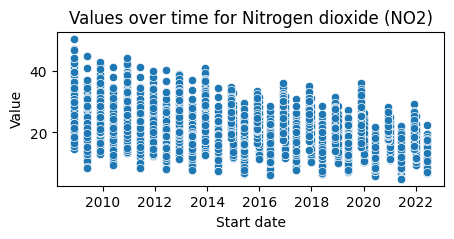

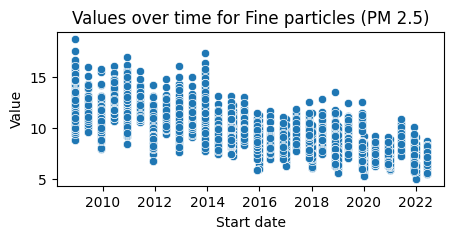

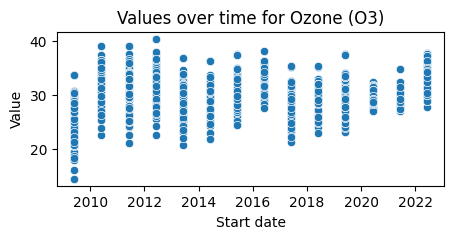

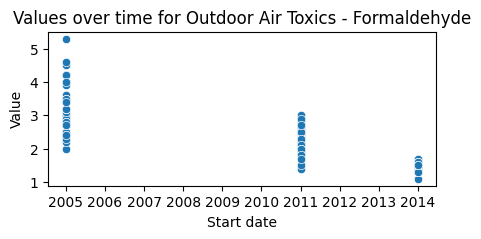

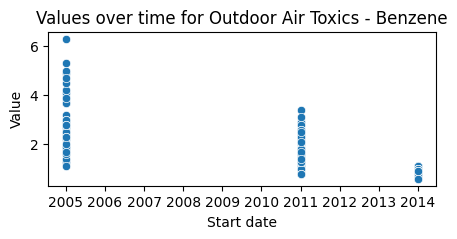

array(['Summer 2022', 'Annual Average 2022', 'Winter 2021-22',
       'Summer 2021', 'Annual Average 2021', 'Winter 2020-21',
       'Summer 2020', 'Annual Average 2020', 'Winter 2019-20',
       'Summer 2019', 'Annual Average 2019', 'Winter 2018-19',
       'Summer 2018', 'Annual Average 2018', 'Winter 2017-18',
       'Summer 2017', 'Annual Average 2017', 'Winter 2016-17',
       'Summer 2016', 'Annual Average 2016', 'Winter 2015-16',
       'Summer 2015', 'Annual Average 2015', 'Winter 2014-15',
       'Summer 2014', 'Winter 2013-14', 'Annual Average 2014',
       'Summer 2013', 'Winter 2012-13', 'Annual Average 2013',
       'Summer 2012', 'Winter 2011-12', 'Annual Average 2012',
       'Summer 2011', 'Winter 2010-11', 'Annual Average 2011',
       'Summer 2010', 'Annual Average 2010', 'Winter 2009-10',
       '2-Year Summer Average 2009-2010', 'Summer 2009', 'Winter 2008-09',
       'Annual Average 2009'], dtype=object)

In [7]:
for name in particle_df["name"].unique():
    this_particle_df = particle_df.query("name == @name")
    fig, ax = plt.subplots(figsize=(5, 2))
    sns.scatterplot(data=this_particle_df, x="start_date", y="data_value", ax=ax)
    plt.title(f"Values over time for {name}")
    plt.xlabel("Start date")
    plt.ylabel("Value")
    plt.show()

particle_df = particle_df[particle_df["name"].isin(['Nitrogen dioxide (NO2)', 'Fine particles (PM 2.5)', 'Ozone (O3)'])]
particle_df["time_period"].unique()

We only have data on outdoor air toxins in 2005, 2011, and 2014. Let's just remove these entries from our dataset, because they are few and out of date!

For NO2, O3, and PM 2.5, we have consistent data starting in 2008 up until 2023. There seem to be some overlapping entries, so let's just keep the ones that are easily comparable to each other! We need to keep different time periods for each of the particle measurements, let's see what the breakdown is.

In [8]:
for name in particle_df["name"].unique():
    print(f"{'*' * 10} {name} {'*' * 10}")
    print(particle_df.query("name == @name")["time_period"].unique())

********** Nitrogen dioxide (NO2) **********
['Summer 2022' 'Annual Average 2022' 'Winter 2021-22' 'Summer 2021'
 'Annual Average 2021' 'Winter 2020-21' 'Summer 2020'
 'Annual Average 2020' 'Winter 2019-20' 'Summer 2019'
 'Annual Average 2019' 'Winter 2018-19' 'Summer 2018'
 'Annual Average 2018' 'Winter 2017-18' 'Summer 2017'
 'Annual Average 2017' 'Winter 2016-17' 'Summer 2016'
 'Annual Average 2016' 'Winter 2015-16' 'Summer 2015'
 'Annual Average 2015' 'Winter 2014-15' 'Summer 2014'
 'Annual Average 2014' 'Winter 2013-14' 'Summer 2013' 'Winter 2012-13'
 'Annual Average 2013' 'Summer 2012' 'Annual Average 2012'
 'Winter 2011-12' 'Summer 2011' 'Winter 2010-11' 'Annual Average 2011'
 'Summer 2010' 'Annual Average 2010' 'Winter 2009-10' 'Summer 2009'
 'Annual Average 2009' 'Winter 2008-09']
********** Fine particles (PM 2.5) **********
['Summer 2022' 'Annual Average 2022' 'Winter 2021-22' 'Summer 2021'
 'Annual Average 2021' 'Winter 2020-21' 'Summer 2020'
 'Annual Average 2020' 'Winter 

For nitrogen dioxide and fine particles, we have measurements for annual averages, winter averages, and summer averages. For ozone, there are just summer averages. For the sake of simplicity, let's just take the summer averages for all three. Perhaps we come back later and look at the overall annual averages.

We'll obviously look at the particles individually because they're not really comparable but let's just plot all three in the same plot for now.

/var/folders/qq/chb4_9t12cq39_ztm318r8nw0000gn/T/ipykernel_78667/2471145386.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  particle_annual_df["year"] = particle_annual_df["time_period"].apply(lambda x: int(x.replace("Summer", "")))


,unique_id,indicator_id,name,measure,measure_info,geo_type_name,geo_join_id,geo_place_name,time_period,start_date,data_value,year
0,825967,375,Nitrogen dioxide (NO2),Mean,ppb,UHF34,104.0,Pelham - Throgs Neck,Summer 2022,2022-06-01,12.0,2022
1,823492,365,Fine particles (PM 2.5),Mean,mcg/m3,CD,307.0,Sunset Park (CD7),Summer 2022,2022-06-01,6.7,2022
2,827012,386,Ozone (O3),Mean,ppb,CD,313.0,Coney Island (CD13),Summer 2022,2022-06-01,37.7,2022
3,827081,386,Ozone (O3),Mean,ppb,UHF34,103.0,Fordham - Bronx Pk,Summer 2022,2022-06-01,31.7,2022
4,827103,386,Ozone (O3),Mean,ppb,UHF42,503.0,Willowbrook,Summer 2022,2022-06-01,34.8,2022


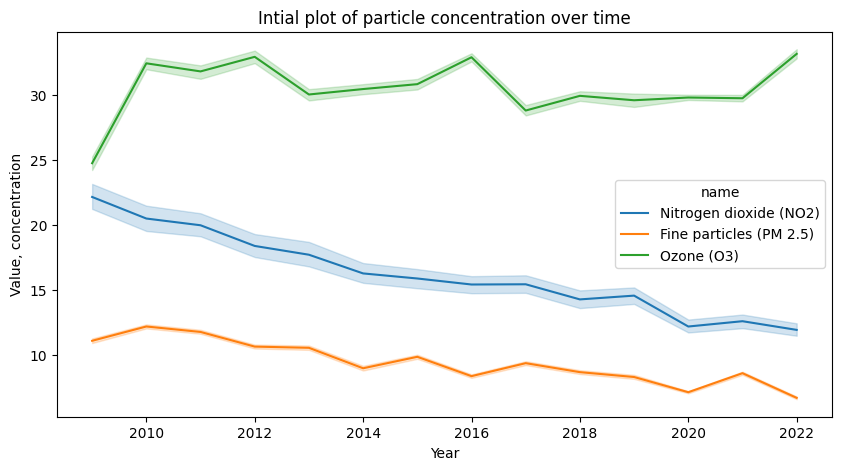

In [9]:
particle_annual_df = particle_df[particle_df["time_period"].apply(lambda x: "Summer 2" in x)]
particle_annual_df["year"] = particle_annual_df["time_period"].apply(lambda x: int(x.replace("Summer", "")))
display(particle_annual_df.head())
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=particle_annual_df, x="year", y="data_value", hue="name", ax=ax)
plt.xlabel("Year")
plt.ylabel("Value, concentration")
plt.title("Intial plot of particle concentration over time")
plt.show()

['2017-2019' '2015-2017' '2012-2014' '2009-2011' '2005-2007']


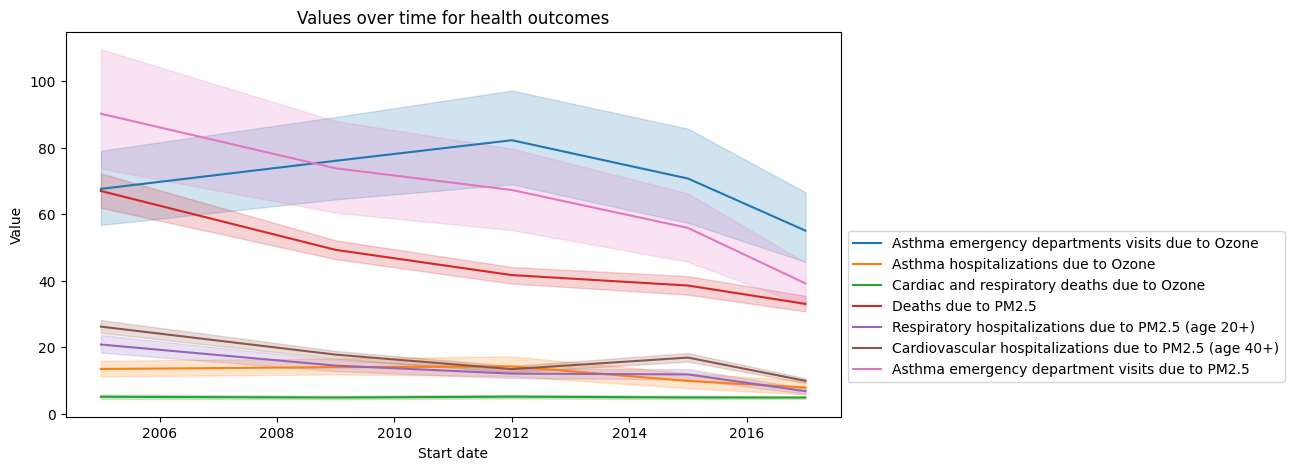

In [10]:
# now take a look at health dataframe
print(health_outcomes_df["time_period"].unique())

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=health_outcomes_df, x="start_date", y="data_value", hue="name", ax=ax)
plt.title(f"Values over time for health outcomes")
plt.xlabel("Start date")
plt.ylabel("Value")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

Given the nature of how these health outcome data have been collected (i.e. not consistent years), let's just take the most recent years of observations (2017-2019).

In [11]:
health_outcomes_recent = health_outcomes_df[health_outcomes_df["time_period"] == "2017-2019"]
health_outcomes_recent

,unique_id,indicator_id,name,measure,measure_info,geo_type_name,geo_join_id,geo_place_name,time_period,start_date,data_value
679,827849,653,Asthma emergency departments visits due to Ozone,Estimated annual rate (under age 18),"per 100,000 children",UHF42,310.0,Lower Manhattan,2017-2019,2017-01-01,40.0
680,827848,653,Asthma emergency departments visits due to Ozone,Estimated annual rate (under age 18),"per 100,000 children",UHF42,309.0,Union Square - Lower East Side,2017-2019,2017-01-01,105.0
682,827841,653,Asthma emergency departments visits due to Ozone,Estimated annual rate (under age 18),"per 100,000 children",UHF42,302.0,Central Harlem - Morningside Heights,2017-2019,2017-01-01,181.0
684,828029,655,Asthma hospitalizations due to Ozone,Estimated annual rate (under age 18),"per 100,000 children",UHF42,210.0,Coney Island - Sheepshead Bay,2017-2019,2017-01-01,8.0
686,828198,652,Cardiac and respiratory deaths due to Ozone,Estimated annual rate,"per 100,000",UHF42,504.0,South Beach - Tottenville,2017-2019,2017-01-01,7.0
...,...,...,...,...,...,...,...,...,...,...,...
435,828097,661,Asthma hospitalizations due to Ozone,Estimated annual rate (age 18+),"per 100,000 adults",UHF42,409.0,Southeast Queens,2017-2019,2017-01-01,1.0
436,828077,661,Asthma hospitalizations due to Ozone,Estimated annual rate (age 18+),"per 100,000 adults",UHF42,210.0,Coney Island - Sheepshead Bay,2017-2019,2017-01-01,2.0
438,828073,661,Asthma hospitalizations due to Ozone,Estimated annual rate (age 18+),"per 100,000 adults",UHF42,206.0,Borough Park,2017-2019,2017-01-01,1.0
440,827462,648,Asthma emergency department visits due to PM2.5,Estimated annual rate (under age 18),"per 100,000 children",UHF42,207.0,East Flatbush - Flatbush,2017-2019,2017-01-01,75.0


# Geography Dataset

In [12]:
# load the geographies provided on github
raw_geo_df = load_and_merge_geo_data()

Let's take our two dataframes we have from the air quality dataset: particles and recent health outcomes, and merge with our geographies to get some preliminary maps.

(5665, 12)
(5665, 13)


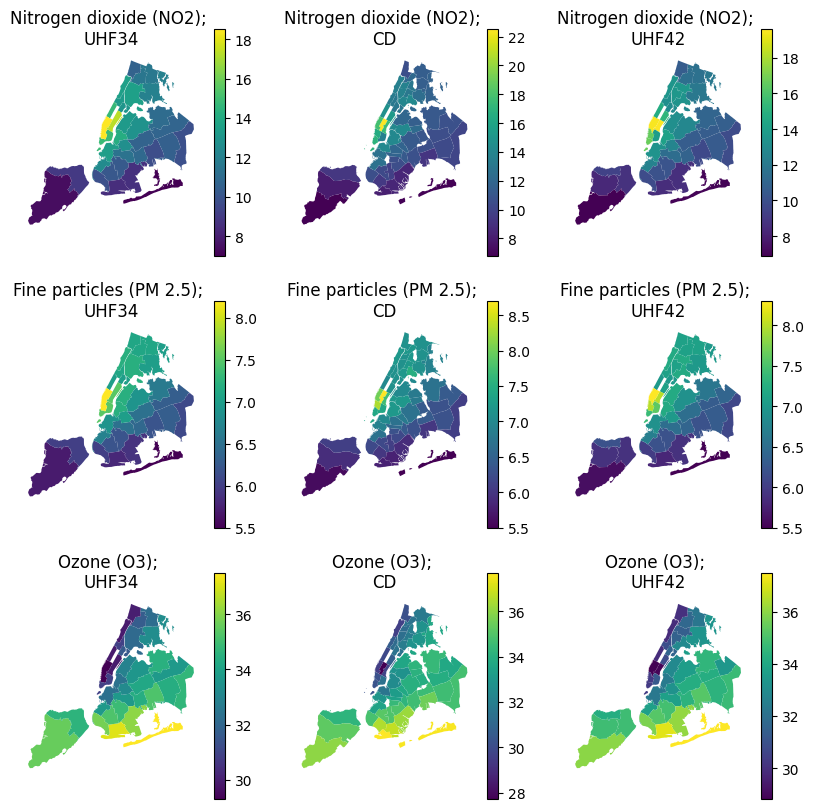

In [13]:
# get particle dataframe with geographies
# particle dataframe contains all of UHF42, UHF32, and CD
particle_gdf = gpd.GeoDataFrame(
    pd.merge(
        particle_annual_df,
        raw_geo_df,
        on=["geo_join_id", "geo_type_name"]
    ),
)
print(particle_annual_df.shape)
print(particle_gdf.shape)


# plot to see differences in between geo types
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
axes_flat = axes.flatten()
for i, values in enumerate(product(particle_gdf["name"].unique(), particle_gdf["geo_type_name"].unique())):
    ax = axes_flat[i]
    name_val, geo_name_val = values
    this_gdf = particle_gdf[(particle_gdf["name"] == name_val) & (particle_gdf["geo_type_name"] == geo_name_val) & (particle_gdf["year"] == 2022)]
    this_gdf.plot(column="data_value", ax=ax, legend=True)
    ax.set_title(f'{name_val}; \n{geo_name_val}')
    ax.axis('off')
    ax.set_aspect('equal')
plt.show()

In [14]:
particle_uhf42_gdf = particle_gdf.query("geo_type_name == 'UHF42'").copy().drop_duplicates()
particle_uhf42_gdf

,unique_id,indicator_id,name,measure,measure_info,geo_type_name,geo_join_id,geo_place_name,time_period,start_date,data_value,year,geometry
4,827103,386,Ozone (O3),Mean,ppb,UHF42,503.0,Willowbrook,Summer 2022,2022-06-01,34.8,2022,"MULTIPOLYGON (((934685.000 166908.000, 934697...."
6,823241,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,401.0,Long Island City - Astoria,Summer 2022,2022-06-01,7.2,2022,"POLYGON ((1010873.510 223071.243, 1010985.119 ..."
11,825793,375,Nitrogen dioxide (NO2),Mean,ppb,UHF42,102.0,Northeast Bronx,Summer 2022,2022-06-01,11.6,2022,"POLYGON ((1025012.990 270794.260, 1025061.481 ..."
12,823262,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,304.0,Upper West Side,Summer 2022,2022-06-01,7.0,2022,"POLYGON ((993981.000 233184.000, 994768.000 23..."
17,827134,386,Ozone (O3),Mean,ppb,UHF42,203.0,Bedford Stuyvesant - Crown Heights,Summer 2022,2022-06-01,33.7,2022,"POLYGON ((999487.000 190339.999, 999528.000 19..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5648,177795,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,309.0,Union Square - Lower East Side,Summer 2009,2009-06-01,12.3,2009,"POLYGON ((987086.000 208579.000, 987654.561 20..."
5649,175896,375,Nitrogen dioxide (NO2),Mean,ppb,UHF42,211.0,Williamsburg - Bushwick,Summer 2009,2009-06-01,23.1,2009,"POLYGON ((1004673.000 199429.000, 1005172.000 ..."
5658,177778,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,203.0,Bedford Stuyvesant - Crown Heights,Summer 2009,2009-06-01,10.9,2009,"POLYGON ((999487.000 190339.999, 999528.000 19..."
5663,222647,386,Ozone (O3),Mean,ppb,UHF42,504.0,South Beach - Tottenville,Summer 2009,2009-06-01,27.8,2009,"MULTIPOLYGON (((955747.000 152098.000, 955765...."


We can see that there are subtle differences between the geography types UHF42, UHF32, and CD but they are somewhat comparable. As we can see below, we only have geographies of type UHF42 for the most recent health outcomes observations. Since we only have UHF42-coded geographic observations in our health outcomes dataset, let's limit our particle dataset to also include only UHF42 observations. It doesn't seem like we will lose too much information doing this, based on the plot above.

(420, 11)
(358, 12)
['UHF42']


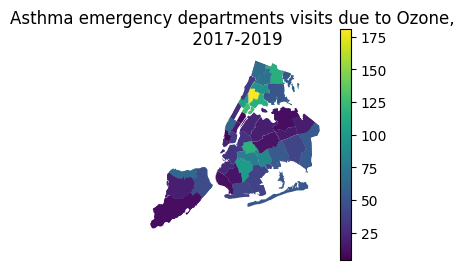

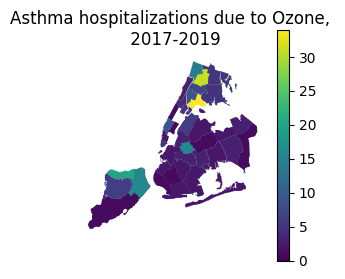

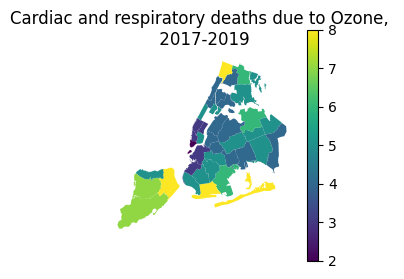

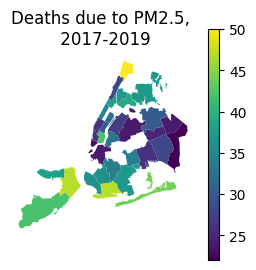

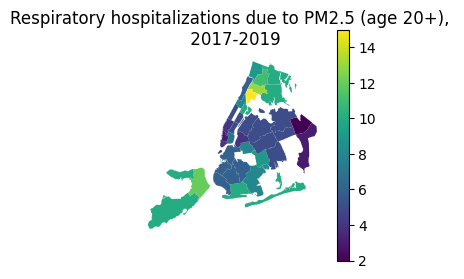

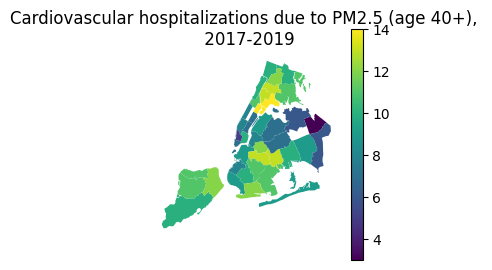

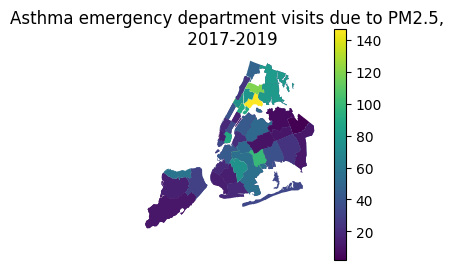

In [15]:
health_outcomes_gdf = gpd.GeoDataFrame(
    pd.merge(
        health_outcomes_recent,
        raw_geo_df,
        on=["geo_join_id", "geo_type_name"]
    ),
).drop_duplicates()
print(health_outcomes_recent.shape)
print(health_outcomes_gdf.shape)

print(health_outcomes_gdf["geo_type_name"].unique())

for name in health_outcomes_gdf["name"].unique():
    fig, ax = plt.subplots(figsize=(3, 3))
    health_outcomes_gdf.query("name == @name").plot(column="data_value", legend=True, ax=ax)
    plt.title(f"{name}, \n 2017-2019")
    ax.axis("off")
    plt.show()

We will dive into this analysis in the next section, but we can already see some parts of Harlem, the Bronx, Staten Island, and south Brooklyn that might be interesting to explore later on.

# More in-depth analysis of air quality dataset alone

* Which neighborhoods have the highest concentrations of particles and in which years? 
* Is there distinct trends in particle concentrations over time?

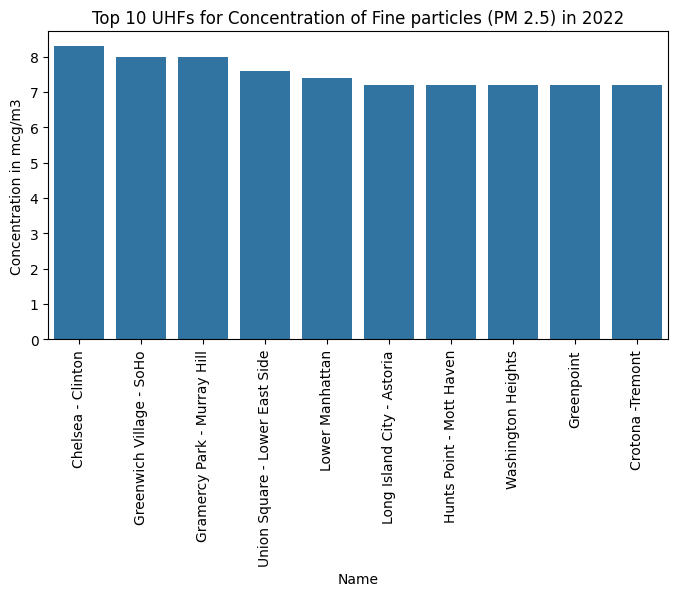

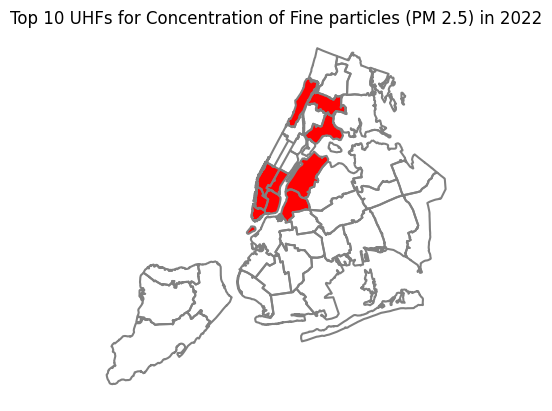

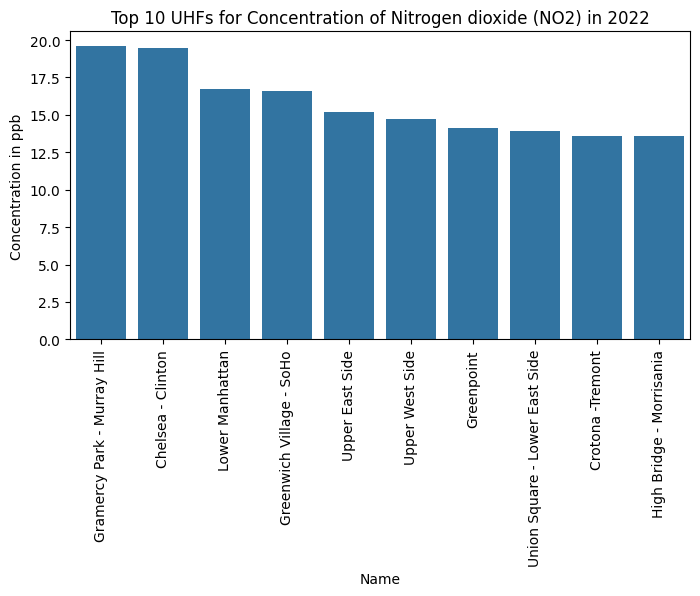

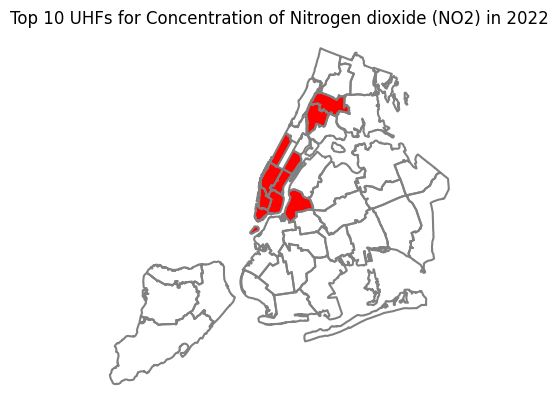

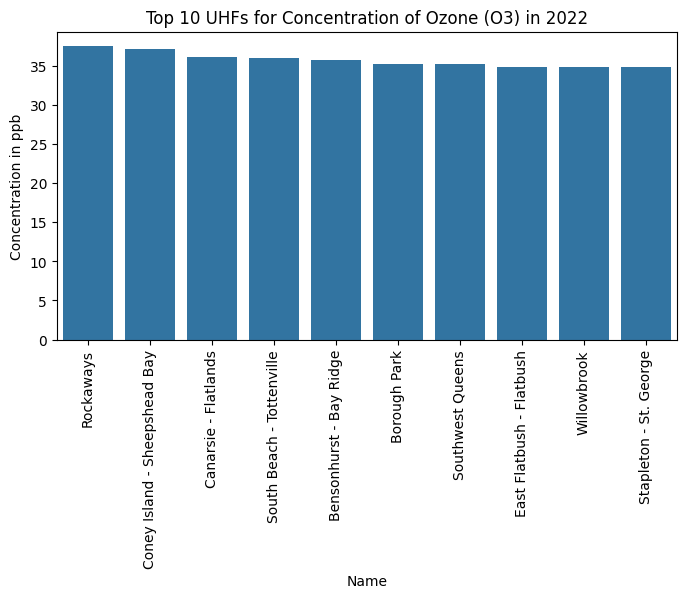

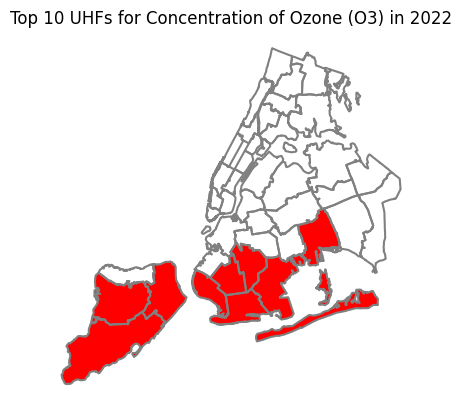

In [16]:
# working with dataframe particle_uhf42_gdf

# most recent year:
most_recent_particle_gdf = particle_uhf42_gdf.sort_values("year").groupby(["name", "measure", "geo_place_name"]).last().reset_index()
for particle_name in most_recent_particle_gdf["name"].unique():
    this_particle_gdf = most_recent_particle_gdf.query("name == @particle_name")
    top_10_geo_gdf = this_particle_gdf.sort_values("data_value", ascending=False).head(10)
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(data=top_10_geo_gdf, x="geo_place_name", y="data_value", ax=ax)
    plt.title(f"Top 10 UHFs for Concentration of {particle_name} in 2022")
    plt.xlabel("Name")
    plt.xticks(rotation=90)
    plt.ylabel(f"Concentration in {top_10_geo_gdf['measure_info'].values[0]}")
    plt.show()

    fig, ax = plt.subplots()
    this_particle_gdf.boundary.plot(color="gray", ax=ax)
    top_10_geo_gdf.plot(color="red", ax=ax)
    ax.axis("off")
    plt.title(f"Top 10 UHFs for Concentration of {particle_name} in 2022")
    plt.show()

For 2022 alone, we can see that areas with high ozone concentration is distinct from those areas with high fine particle and NO2 concentrations.

The top 10 UHFs for fine particles and nitrogen dioxide are concentrated in lower Manhattan, western Queens, and the Bronx. For ozone, the areas are in Staten Island and southern Brooklyn.

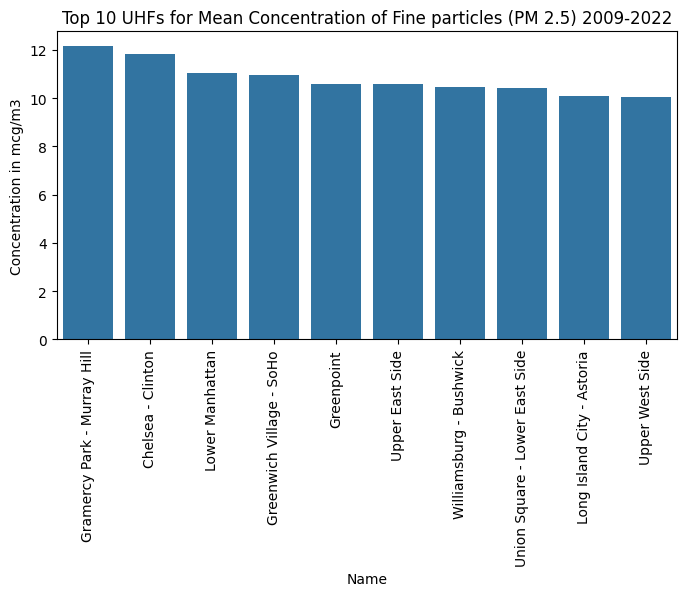

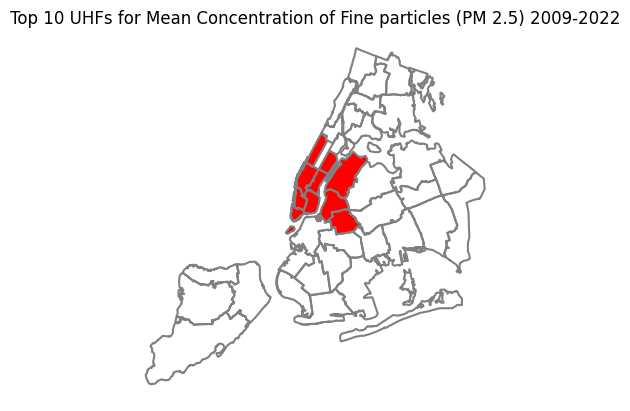

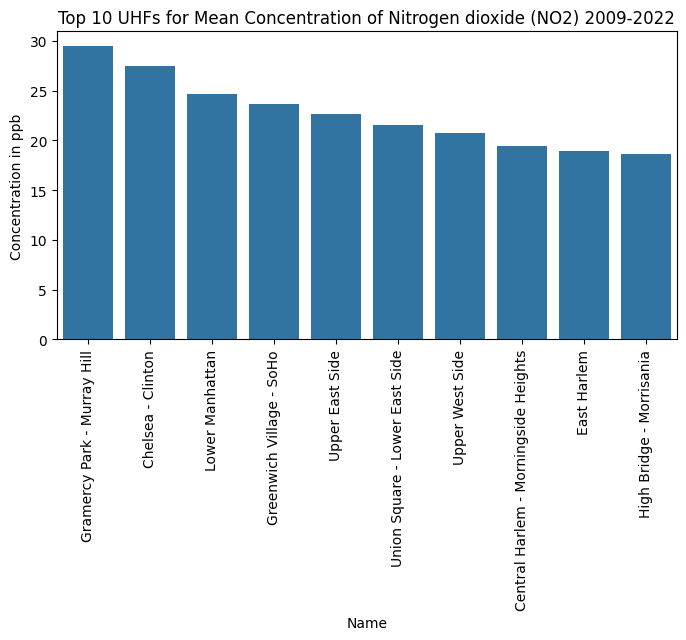

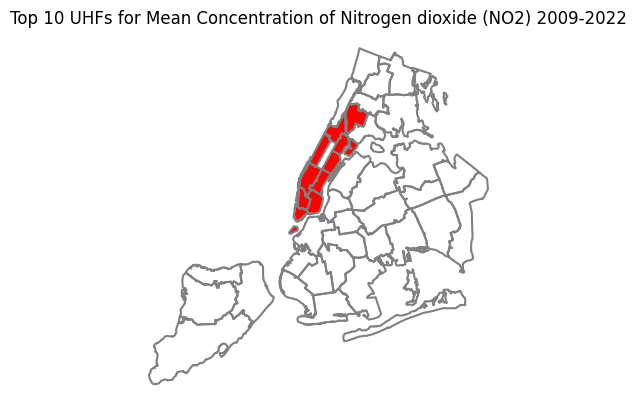

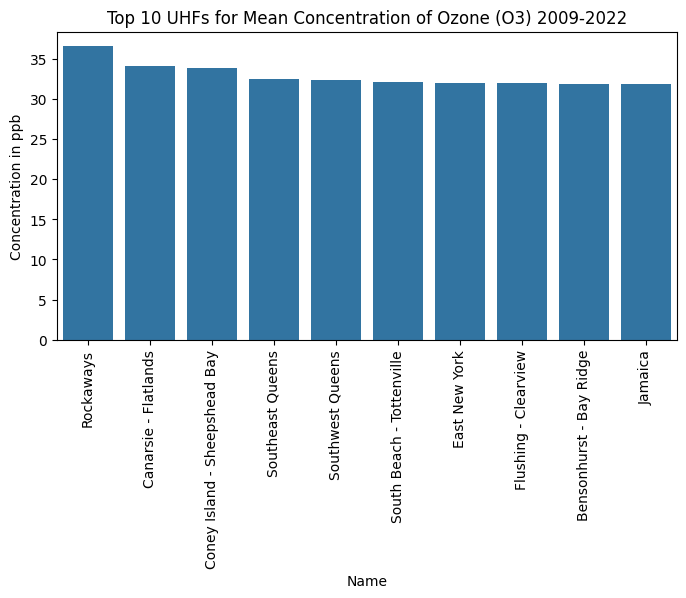

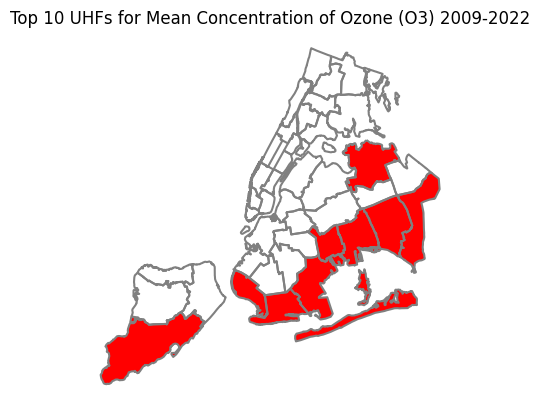

In [17]:
# average across years, not just in the most recent year in our dataset.

avg_particle_gdf = gpd.GeoDataFrame(particle_uhf42_gdf.groupby(["name", "measure", "geo_place_name", "measure_info", "geometry"])["data_value"].mean().reset_index())
for particle_name in avg_particle_gdf["name"].unique():
    this_particle_gdf = avg_particle_gdf.query("name == @particle_name")
    top_10_geo_gdf = this_particle_gdf.sort_values("data_value", ascending=False).head(10)
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(data=top_10_geo_gdf, x="geo_place_name", y="data_value", ax=ax)
    plt.title(f"Top 10 UHFs for Mean Concentration of {particle_name} 2009-2022")
    plt.xlabel("Name")
    plt.xticks(rotation=90)
    plt.ylabel(f"Concentration in {top_10_geo_gdf['measure_info'].values[0]}")
    plt.show()

    fig, ax = plt.subplots()
    this_particle_gdf.boundary.plot(color="gray", ax=ax)
    top_10_geo_gdf.plot(color="red", ax=ax)
    ax.axis("off")
    plt.title(f"Top 10 UHFs for Mean Concentration of {particle_name} 2009-2022")
    plt.show()

We see a slightly different profile for mean concentration over all years, but again we see similar overlap between areas of high NO2 and fine particle concentration and a large difference in areas with high ozone concentration. Let's take the union of the areas with the highest concentration in 2022 and the highest mean concentration and plot the concentrations over time.

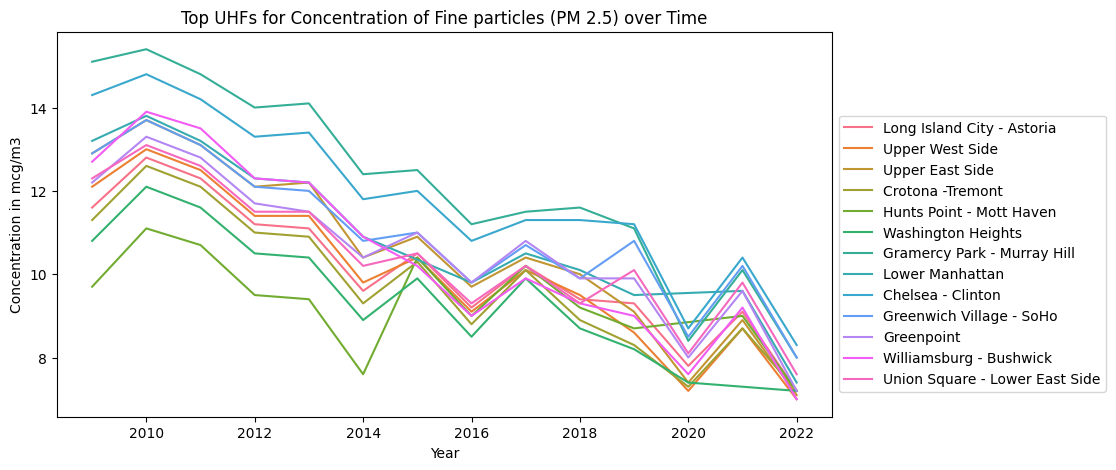

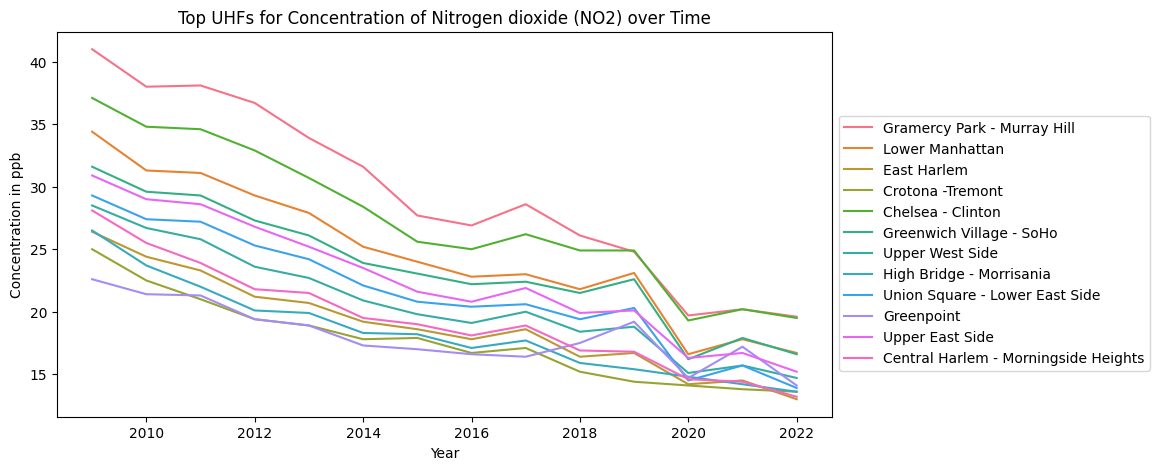

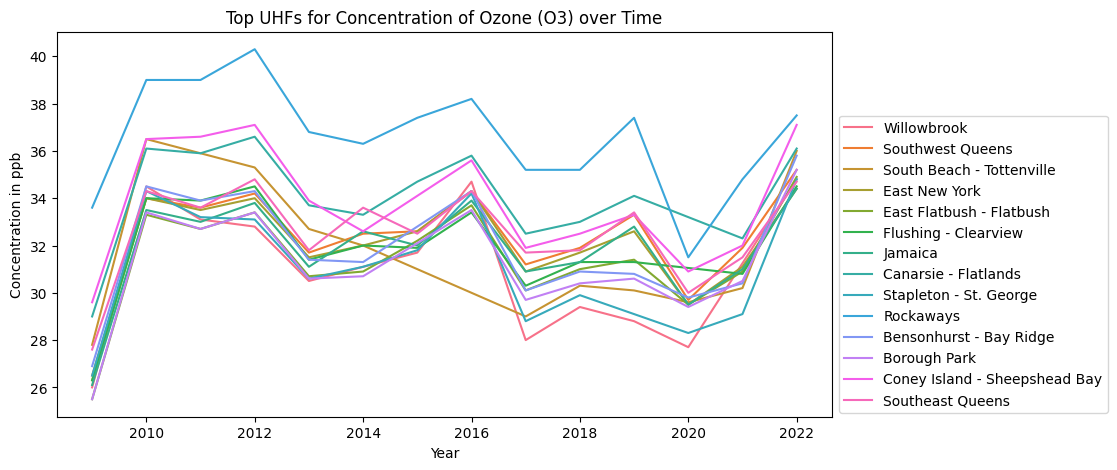

In [18]:
for particle_name in most_recent_particle_gdf["name"].unique():
    top_2022_geo = most_recent_particle_gdf.query("name == @particle_name").sort_values("data_value", ascending=False).head(10)["geo_place_name"]
    top_mean_geo = avg_particle_gdf.query("name == @particle_name").sort_values("data_value", ascending=False).head(10)["geo_place_name"]
    union_geo = set(top_2022_geo).union(set(top_mean_geo))
    union_geo_df = particle_uhf42_gdf[(particle_uhf42_gdf["geo_place_name"].isin(union_geo)) & (particle_uhf42_gdf["name"] == particle_name)]
    
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.lineplot(union_geo_df.rename(columns={"geo_place_name": "UHF"}), x="year", y="data_value", hue="UHF", ax=ax)
    plt.title(f"Top UHFs for Concentration of {particle_name} over Time")
    plt.xlabel("Year")
    plt.ylabel(f"Concentration in {union_geo_df['measure_info'].values[0]}")
    plt.legend(bbox_to_anchor=(1.0, 0.8))
    plt.show()

Here we can see that the concentrations of fine particles and nitrogen dioxide have been steadily decreasing across high concentration areas since 2009. The profile over time for ozone looks different. There's no clear pattern of increasing or decreasing concentrations, and greater volatility year to year.

Now, let's take a similar look at the health outcomes dataset that we have.

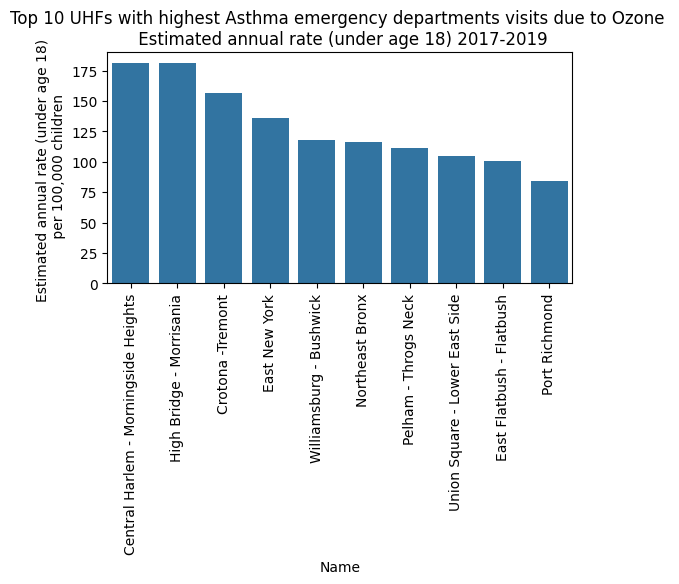

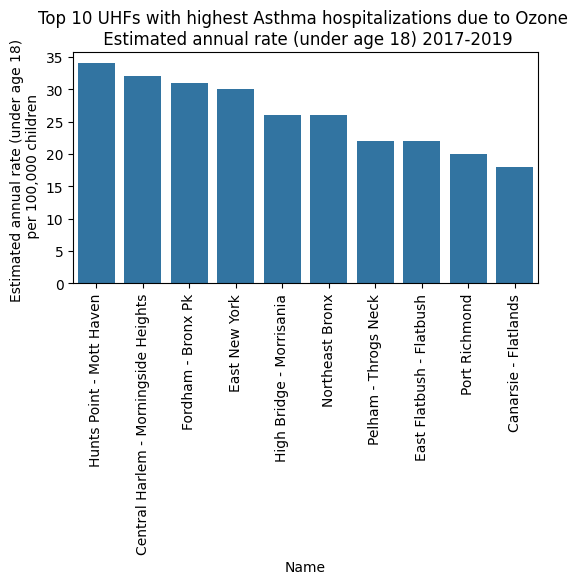

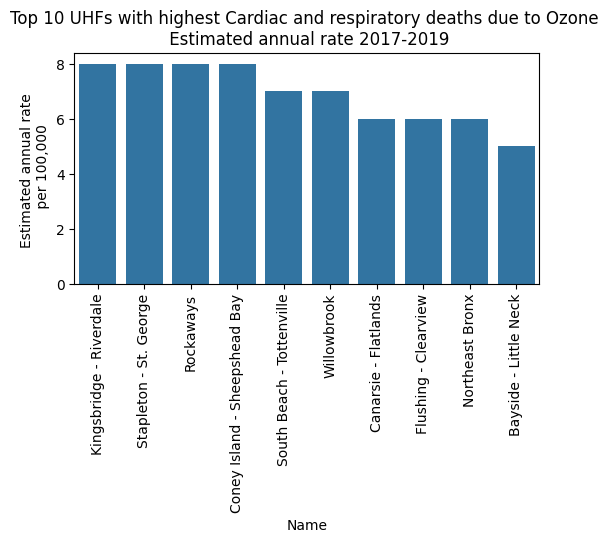

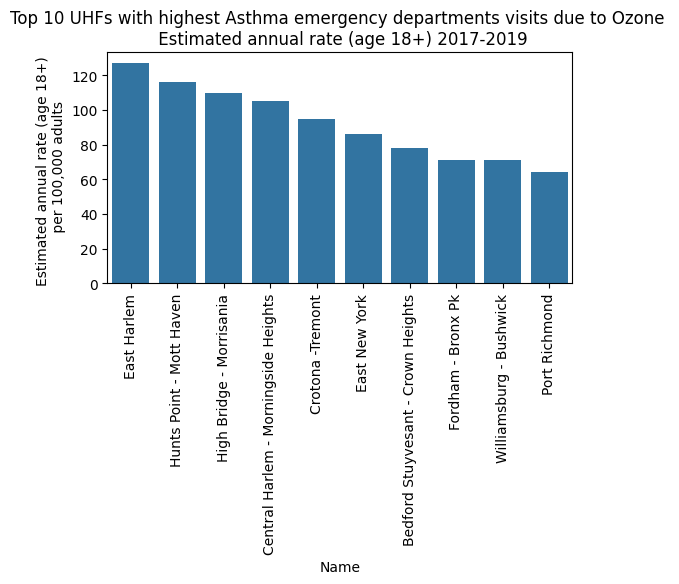

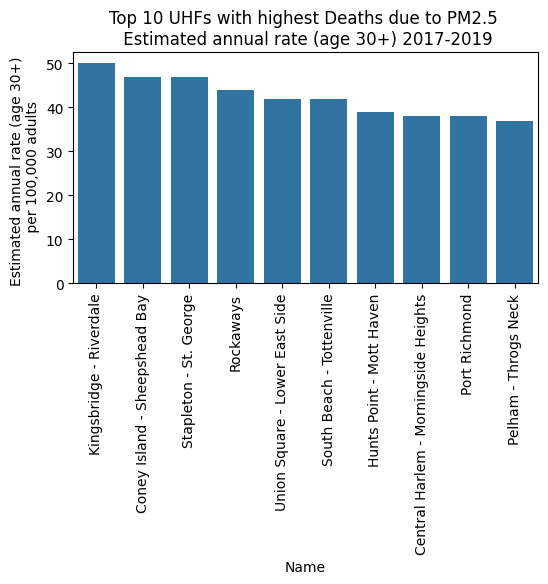

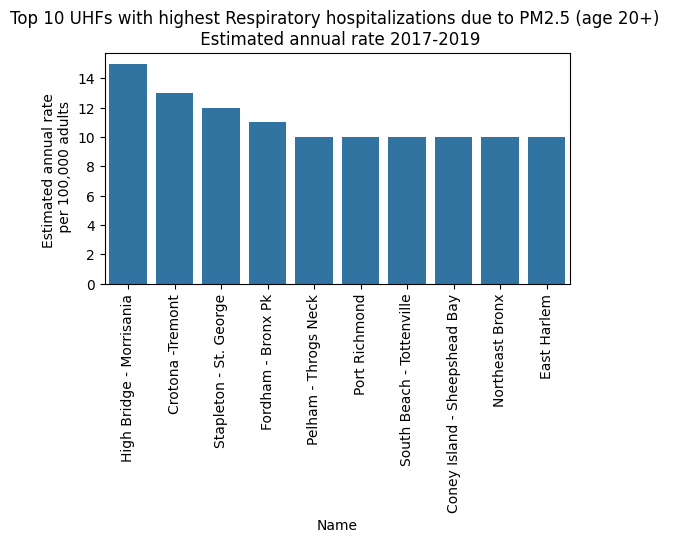

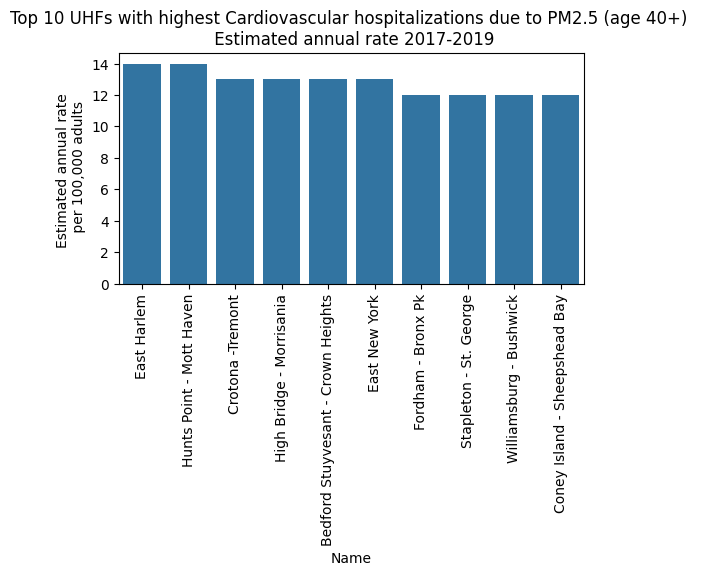

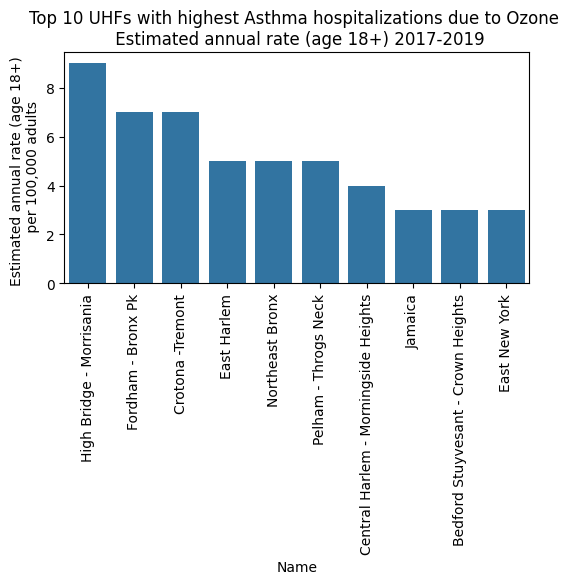

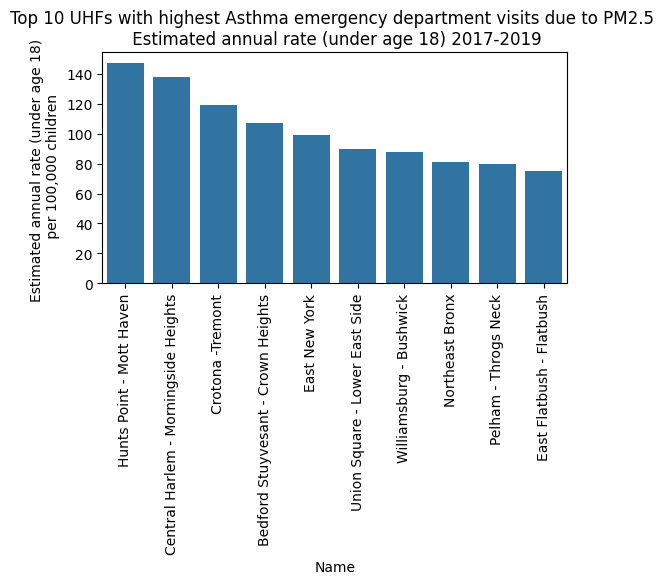

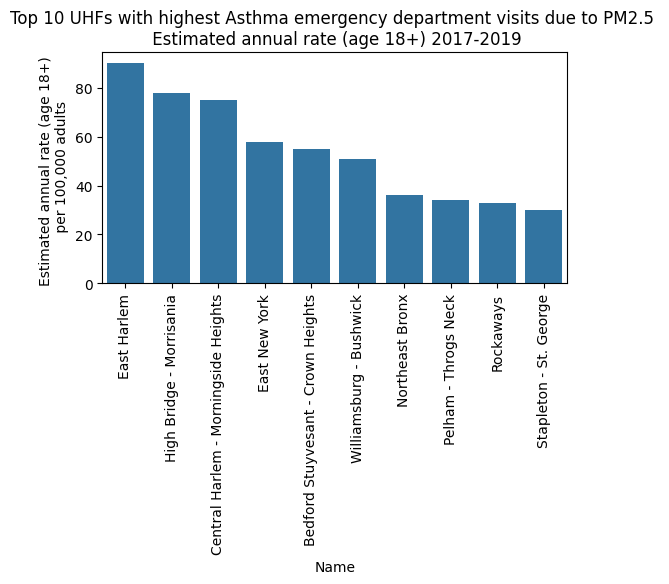

In [46]:
for _, health_outcomes_name_measure in health_outcomes_gdf[["name", "measure"]].drop_duplicates().iterrows():
    health_outcomes_name = health_outcomes_name_measure["name"]
    health_outcomes_measure = health_outcomes_name_measure["measure"]
    geo_health_gdf = health_outcomes_gdf.query('name == @health_outcomes_name & measure == @health_outcomes_measure')
    top_10_gdf = geo_health_gdf.sort_values("data_value", ascending=False).head(10)
    fig, ax = plt.subplots(figsize=(6, 3))
    sns.barplot(data=top_10_gdf, x="geo_place_name", y="data_value", ax=ax)
    plt.title(f"Top 10 UHFs with highest {health_outcomes_name} \n {health_outcomes_measure} 2017-2019")
    plt.xlabel("Name")
    plt.xticks(rotation=90)
    plt.ylabel(f"{top_10_gdf['measure'].values[0]} \n {top_10_gdf['measure_info'].values[0]}")
    plt.show()

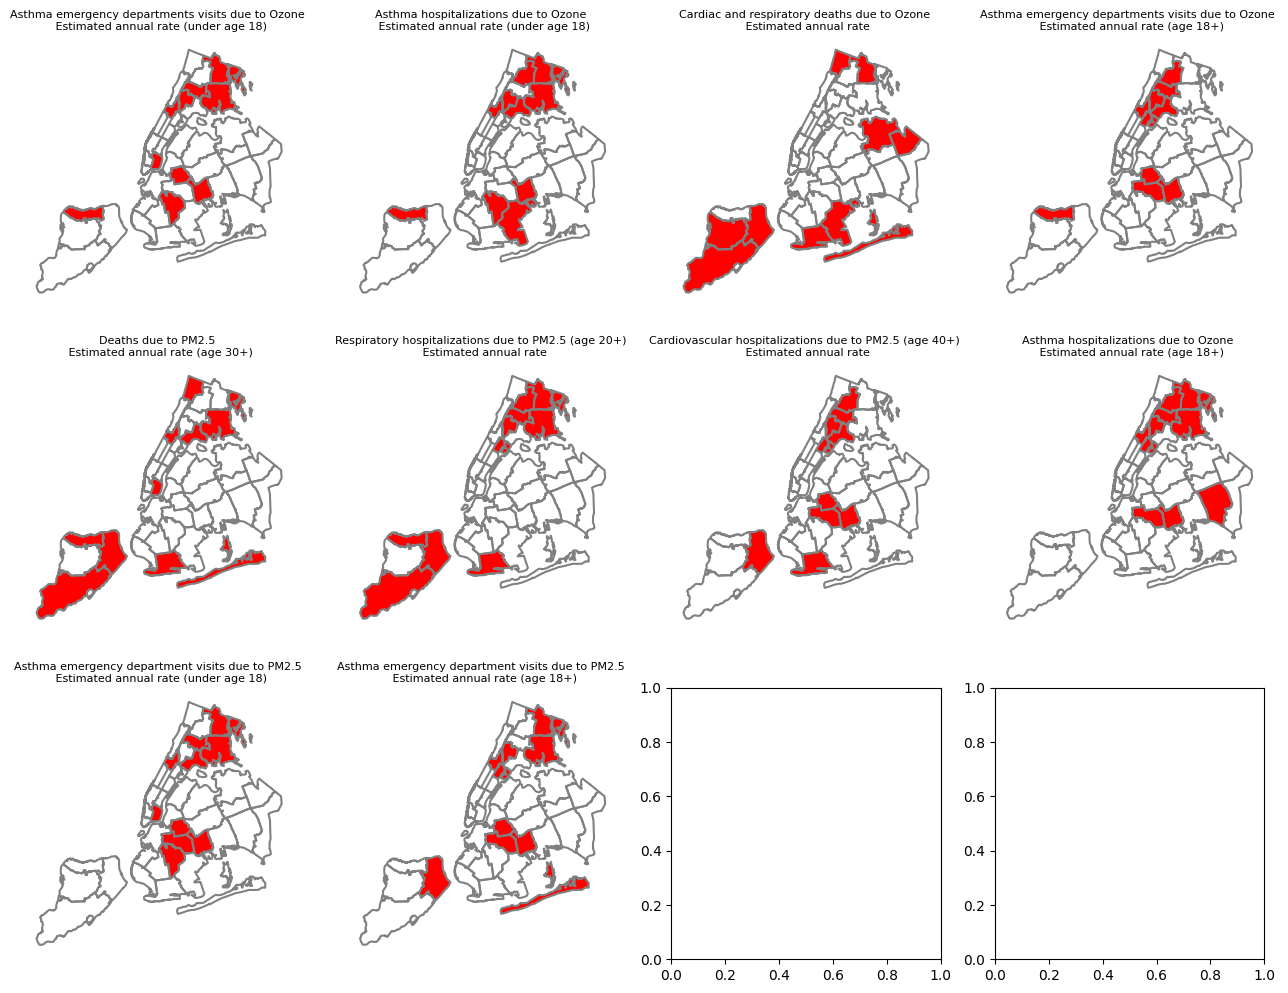

In [60]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
axes_flat = axes.flatten()
i = 0
for _, health_outcomes_name_measure in health_outcomes_gdf[["name", "measure"]].drop_duplicates().iterrows():
    ax = axes_flat[i]
    health_outcomes_name = health_outcomes_name_measure["name"]
    health_outcomes_measure = health_outcomes_name_measure["measure"]
    geo_health_gdf = health_outcomes_gdf.query('name == @health_outcomes_name & measure == @health_outcomes_measure')
    top_10_gdf = geo_health_gdf.sort_values("data_value", ascending=False).head(10)
    health_outcomes_gdf[["geometry"]].drop_duplicates().boundary.plot(color="gray", ax=ax)
    top_10_gdf.plot(color="red", ax=ax)
    ax.axis("off")
    ax.set_title(f'{health_outcomes_name} \n {health_outcomes_measure}', size=8)
    i+=1
plt.show()

I think the main takeaway here is that the areas highlighted in terms of high negative health outcomes (hopsitalizations, ER visits) are not necessarily the same as those with high concentrations of particulate matter that were highlighted. We need to do a more direct comparison, however, since we are considering different metrics and years.

What I'd like to do:
* Merge together the particle concentration dataset and the 

# 2020 Census Data

We will limit to only look at years

In [21]:
acs_data_handler = ACSDataHandler(const.ACS_VARS.keys(), range(2020, 2023))
acs5_df = acs_data_handler.load_acs5_data()
acs5_df = acs_data_handler.aggregate_zcta_to_uhf(acs5_df)
acs5_df = acs5_df[acs5_df["median_household_income"] > 0]
acs5_df

/Users/nataliegable/work/nyc_air_quality/extract.py:149: FutureWarning: The provided callable <function sum at 0x109ae1a80> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  merge_df["uhf_tot_pop"] = merge_df.groupby("uhfcode")["population"].transform(


,uhfcode,year,median_household_income,gini_index
0,101,2020,154054,1.0209
1,101,2021,159416,1.0157
2,101,2022,178198,0.9795
3,102,2020,244057,1.7752
4,102,2021,259767,1.8102
...,...,...,...,...
118,502,2021,219425,1.4793
119,502,2022,239098,1.4563
123,504,2020,502110,2.0893
124,504,2021,530613,2.0821


In [22]:
pd.merge(
    acs5_df.query("year == 2022"),
    health_outcomes_gdf,
    left_on="uhfcode",
    right_on="geo_join_id"
)

,uhfcode,year,median_household_income,gini_index,unique_id,indicator_id,name,measure,measure_info,geo_type_name,geo_join_id,geo_place_name,time_period,start_date,data_value,geometry
0,101,2022,178198,0.9795,827475,648,Asthma emergency department visits due to PM2.5,Estimated annual rate (under age 18),"per 100,000 children",UHF42,101.0,Kingsbridge - Riverdale,2017-2019,2017-01-01,48.0,"POLYGON ((1017992.894 269222.964, 1017812.000 ..."
1,101,2022,178198,0.9795,828013,655,Asthma hospitalizations due to Ozone,Estimated annual rate (under age 18),"per 100,000 children",UHF42,101.0,Kingsbridge - Riverdale,2017-2019,2017-01-01,14.0,"POLYGON ((1017992.894 269222.964, 1017812.000 ..."
2,101,2022,178198,0.9795,827486,651,Cardiovascular hospitalizations due to PM2.5 (...,Estimated annual rate,"per 100,000 adults",UHF42,101.0,Kingsbridge - Riverdale,2017-2019,2017-01-01,10.0,"POLYGON ((1017992.894 269222.964, 1017812.000 ..."
3,101,2022,178198,0.9795,827571,639,Deaths due to PM2.5,Estimated annual rate (age 30+),"per 100,000 adults",UHF42,101.0,Kingsbridge - Riverdale,2017-2019,2017-01-01,50.0,"POLYGON ((1017992.894 269222.964, 1017812.000 ..."
4,101,2022,178198,0.9795,827582,650,Respiratory hospitalizations due to PM2.5 (age...,Estimated annual rate,"per 100,000 adults",UHF42,101.0,Kingsbridge - Riverdale,2017-2019,2017-01-01,9.0,"POLYGON ((1017992.894 269222.964, 1017812.000 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,504,2022,559680,2.0935,827527,651,Cardiovascular hospitalizations due to PM2.5 (...,Estimated annual rate,"per 100,000 adults",UHF42,504.0,South Beach - Tottenville,2017-2019,2017-01-01,10.0,"MULTIPOLYGON (((955747.000 152098.000, 955765...."
278,504,2022,559680,2.0935,827386,657,Asthma emergency department visits due to PM2.5,Estimated annual rate (age 18+),"per 100,000 adults",UHF42,504.0,South Beach - Tottenville,2017-2019,2017-01-01,7.0,"MULTIPOLYGON (((955747.000 152098.000, 955765...."
279,504,2022,559680,2.0935,827530,639,Deaths due to PM2.5,Estimated annual rate (age 30+),"per 100,000 adults",UHF42,504.0,South Beach - Tottenville,2017-2019,2017-01-01,42.0,"MULTIPOLYGON (((955747.000 152098.000, 955765...."
280,504,2022,559680,2.0935,827434,648,Asthma emergency department visits due to PM2.5,Estimated annual rate (under age 18),"per 100,000 children",UHF42,504.0,South Beach - Tottenville,2017-2019,2017-01-01,11.0,"MULTIPOLYGON (((955747.000 152098.000, 955765...."


# Takeaways



# Next Steps

Given more time, I'd like to come back to this project. Here are a few lingering questions/places to start:
* 